<a href="https://colab.research.google.com/github/pabi1234810/Potato_Leaf_Disease/blob/main/Potato_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: INSTALL AND IMPORT LIBRARIES

In [1]:
import numpy as np  # For numerical operations and array manipulation
import pandas as pd  # For data manipulation (if needed for reports)
import matplotlib.pyplot as plt  # For plotting images and results
import seaborn as sns  # For beautiful visualizations like confusion matrix
import os  # For file and directory operations
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split  # To split data into train/test sets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation

In [ ]:
from google.colab import files

# Ensure the zip_filename variable is defined
# (it should be from previous cells, but we'll include it for clarity)
zip_filename = 'image_archive.zip'

if os.path.exists(zip_filename):
    files.download(zip_filename)
    print(f"Downloading '{zip_filename}'...")
else:
    print(f"Error: Zip file '{zip_filename}' not found. Please ensure it was created successfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # For training optimization

# Set random seeds for reproducibility (so results are consistent)
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✓ All libraries imported successfully!
TensorFlow version: 2.19.0


In [2]:
!nvidia-smi

Sun Dec 28 15:53:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [14]:
# @title
import os

# List the contents of the Potato_Leaf directory
print(f"Contents of '/content/gdrive/MyDrive/Potato_Leaf':\n")
!ls -F '/content/gdrive/MyDrive/Potato_Leaf'


Contents of '/content/gdrive/MyDrive/Potato_Leaf':

'001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'
'002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'
'0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG'
'00695906-210d-4a9d-822e-986a17384115___RS_LB 4026.JPG'
'006cc01a-1888-4326-9b62-a65cb55a6377___RS_LB 5207.JPG'
'0085ef03-aec3-431a-99a1-de286e10c0cf___RS_LB 2949.JPG'
'009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'
'00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG'
'00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG'
'00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'
'0114b195-844c-4978-93a9-b0d5aae010f1___RS_LB 2738.JPG'
'01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517.JPG'
'0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG'
'01a8cc9f-074a-4866-87c8-bb5a9e3895b4___RS_LB 2968.JPG'
'01ad74ce-eb28-42c7-9204-778d17cfd45c___RS_LB 2669.JPG'
'0201bf8e-27e3-4c92-ae97-2fb4f665b5d3___RS_LB 4320.JPG'
'02212653-e92b-49aa-96b7-94

In [15]:
data_dir = '/content/gdrive/MyDrive/Potato_Leaf'
class_names = ['Early_Blight', 'Late_Blight', 'Healthy']

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    print(f"Ensured directory exists: {class_dir}")

print("✓ Class directories created or already exist.")

Ensured directory exists: /content/gdrive/MyDrive/Potato_Leaf/Early_Blight
Ensured directory exists: /content/gdrive/MyDrive/Potato_Leaf/Late_Blight
Ensured directory exists: /content/gdrive/MyDrive/Potato_Leaf/Healthy
✓ Class directories created or already exist.


In [16]:
import shutil

print("✓ shutil imported.")

✓ shutil imported.


In [17]:
print(f"Starting to sort images from '{data_dir}' into class subfolders...")

# Define the mapping from filename identifier to class name
class_mapping = {
    '___RS_Early.B': 'Early_Blight',
    '___RS_LB': 'Late_Blight',
    '___RS_HL': 'Healthy'
}

# List all files in the main data directory
all_files = os.listdir(data_dir)

# Filter out only image files that are not directories themselves
image_files_to_sort = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(data_dir, f))]

# Counter for sorted files
sorted_count = 0

for filename in image_files_to_sort:
    source_path = os.path.join(data_dir, filename)
    destination_dir = None

    # Determine the class based on the filename
    for identifier, class_name in class_mapping.items():
        if identifier in filename:
            destination_dir = os.path.join(data_dir, class_name)
            break

    # Move the file if a destination directory was found
    if destination_dir:
        try:
            shutil.move(source_path, destination_dir)
            # print(f"Moved '{filename}' to '{destination_dir}'")
            sorted_count += 1
        except Exception as e:
            print(f"Error moving '{filename}': {e}")
    else:
        print(f"Warning: Could not determine class for '{filename}'. Skipping.")

print(f"\n✓ Finished sorting. Moved {sorted_count} images to their respective class subfolders.")

# Optional: Verify if there are any files left in the root data_dir that shouldn't be there
remaining_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
if remaining_files:
    print(f"Note: {len(remaining_files)} files still remain in the root directory after sorting. E.g., {remaining_files[0]}")
else:
    print("All identifiable image files have been sorted out of the root directory.")

Starting to sort images from '/content/gdrive/MyDrive/Potato_Leaf' into class subfolders...

✓ Finished sorting. Moved 2152 images to their respective class subfolders.
All identifiable image files have been sorted out of the root directory.


In [18]:
print(f"\nContents of main data directory '{data_dir}':")
print(os.listdir(data_dir))

print("\n--- Verifying contents of class subdirectories ---")
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        files_in_class = os.listdir(class_path)
        num_files = len(files_in_class)
        print(f"\nClass '{class_name}' contains {num_files} files. Sample files:")
        # Displaying up to 5 files or all if less than 5
        for i, file in enumerate(files_in_class[:5]):
            print(f"  - {file}")
        if num_files > 5:
            print(f"  ...and {num_files - 5} more.")
    else:
        print(f"\nWarning: Directory for class '{class_name}' not found at {class_path}")


Contents of main data directory '/content/gdrive/MyDrive/Potato_Leaf':
['Early_Blight', 'Late_Blight', 'Healthy']

--- Verifying contents of class subdirectories ---

Class 'Early_Blight' contains 1000 files. Sample files:
  - 232c8d25-3bfe-41ea-b24f-2b3629a0253a___RS_Early.B 9200.JPG
  - 24a34259-1c47-4e87-ac83-5decf37b42e4___RS_Early.B 6896.JPG
  - 203357f4-1deb-42b2-99ed-32df34aa166c___RS_Early.B 6780.JPG
  - 24ced43c-a862-4e3d-8300-dffd350de2c4___RS_Early.B 6957.JPG
  - 26d2af6a-f52e-457c-8006-fa106ad39fbe___RS_Early.B 8586.JPG
  ...and 995 more.

Class 'Late_Blight' contains 1000 files. Sample files:
  - 01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517.JPG
  - 02c8ff21-4e0a-4326-ba8f-089e5cb45b74___RS_LB 4089.JPG
  - 0201bf8e-27e3-4c92-ae97-2fb4f665b5d3___RS_LB 4320.JPG
  - 02282fee-ba3f-460e-91e0-630204ab96c2___RS_LB 5031.JPG
  - 0fe7786d-0e2f-4705-839d-898f1d9214b0___RS_LB 2836.JPG
  ...and 995 more.

Class 'Healthy' contains 152 files. Sample files:
  - dca8ac5c-b925-435a-a5e

In [21]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42 # for reproducibility
)

for images, labels in dataset.take(1).as_numpy_iterator():
    break

print(f"Shape of one batch of images: {images.shape}")
print(f"Shape of one batch of labels: {labels.shape}")
print(f"Number of images in this batch: {len(images)}")
print(f"Number of labels in this batch: {len(labels)}")

Found 2152 files belonging to 3 classes.
Shape of one batch of images: (32, 256, 256, 3)
Shape of one batch of labels: (32,)
Number of images in this batch: 32
Number of labels in this batch: 32


**Reasoning**:
The subtask requires displaying the data type and values of the labels from the extracted sample batch. This step will complete the remaining instructions for the subtask.



In [22]:
print(f"Data type of labels: {labels.dtype}")
print(f"Values of labels from the sample batch: {labels}")

Data type of labels: int32
Values of labels from the sample batch: [1 2 1 1 2 0 0 1 1 1 1 0 0 1 1 0 0 2 0 0 1 0 0 0 1 0 0 1 0 2 2 0]


In [23]:
len(dataset)


68

In [24]:
# Printing the First Image
for image_batch in dataset.take(1) :
  print("Image: ", image_batch[0].numpy())
  print("Shape: ", image_batch[0].shape)

Image:  [[[[146 135 139]
   [166 155 159]
   [160 149 153]
   ...
   [135 123 127]
   [102  90  94]
   [116 104 108]]

  [[142 131 135]
   [153 142 146]
   [151 140 144]
   ...
   [124 112 116]
   [113 101 105]
   [113 101 105]]

  [[145 134 138]
   [144 133 137]
   [147 136 140]
   ...
   [117 105 109]
   [123 111 115]
   [108  96 100]]

  ...

  [[161 150 154]
   [158 147 151]
   [158 147 151]
   ...
   [125 111 111]
   [133 119 119]
   [120 106 106]]

  [[160 149 153]
   [159 148 152]
   [161 150 154]
   ...
   [123 109 109]
   [127 113 113]
   [120 106 106]]

  [[160 149 153]
   [162 151 155]
   [167 156 160]
   ...
   [100  86  86]
   [142 128 128]
   [130 116 116]]]


 [[[188 177 175]
   [200 189 187]
   [195 184 182]
   ...
   [157 145 145]
   [162 150 150]
   [166 154 154]]

  [[191 180 178]
   [202 191 189]
   [198 187 185]
   ...
   [157 145 145]
   [159 147 147]
   [161 149 149]]

  [[193 182 180]
   [203 192 190]
   [198 187 185]
   ...
   [161 149 149]
   [161 149 149]
   

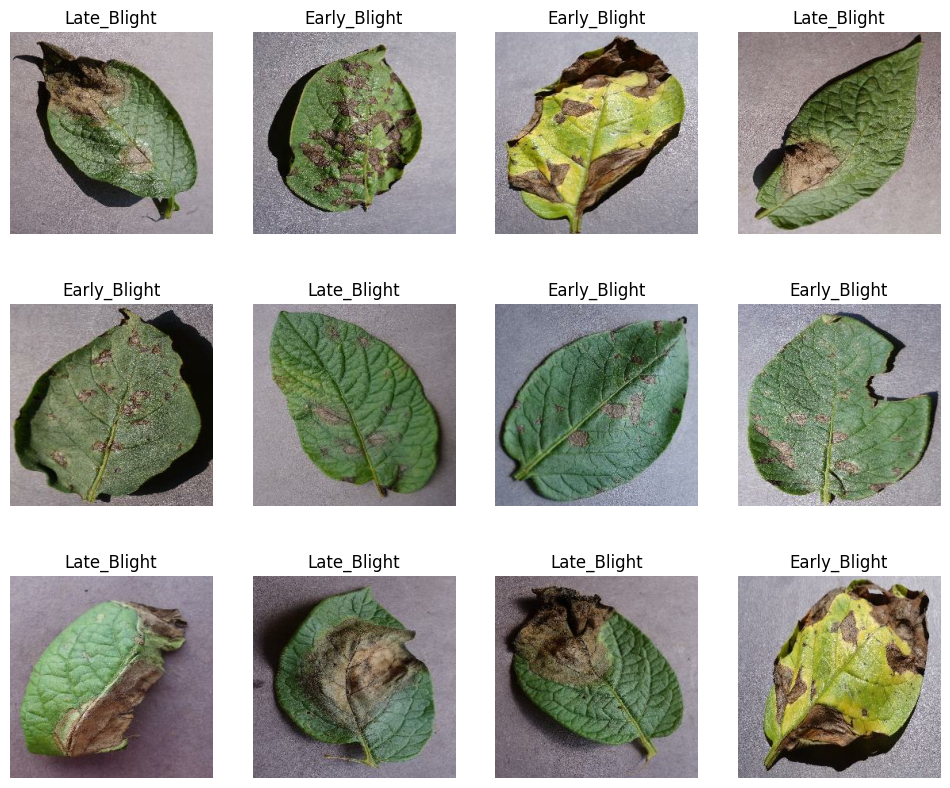

In [25]:
# Visualizing random 12 images from the 1st batch along with labels
plt.figure(figsize=(12, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [26]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),  # Specify input_shape here
    layers.Rescaling(1./255)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [31]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),  # Remove 'experimental.preprocessing'
  layers.RandomRotation(0.2),  # Remove 'experimental.preprocessing'
])

In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape

(256, 256, 3)

In [36]:
from tensorflow.keras import models, layers # Added models import here

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,507 (2.25 MB)

 Trainable params: 589,507 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the epoch with the best value of the monitored metric
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping],
)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - accuracy: 0.8853 - loss: 0.2954 - val_accuracy: 0.9271 - val_loss: 0.2203
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.8981 - loss: 0.2590 - val_accuracy: 0.9062 - val_loss: 0.2414
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.9008 - loss: 0.2490 - val_accuracy: 0.9167 - val_loss: 0.2432
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 0.9169 - loss: 0.1997 - val_accuracy: 0.9167 - val_loss: 0.2539


In [43]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9036 - loss: 0.1911


In [44]:
scores

[0.2094240039587021, 0.89453125]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

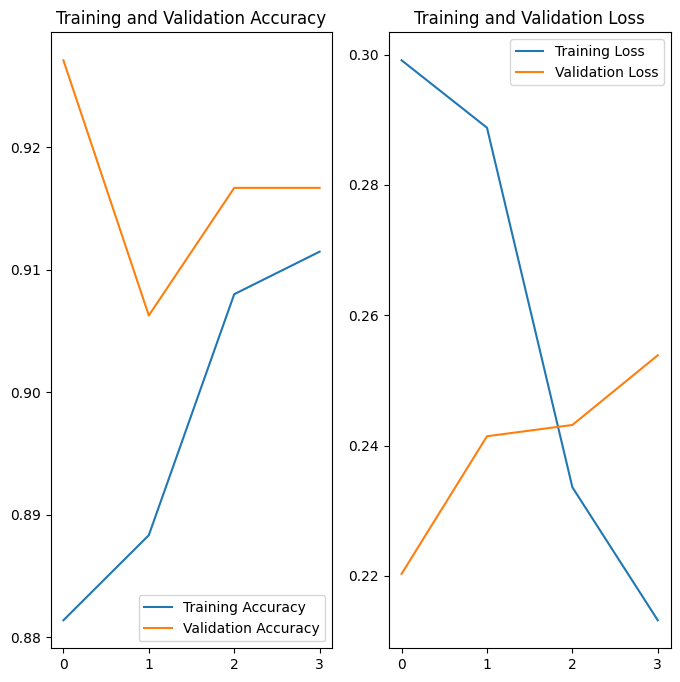

In [47]:
plt.figure(figsize=(8, 8))
epochs_run = len(acc) # Get the actual number of epochs completed
plt.subplot(1, 2, 1)
plt.plot(range(epochs_run), acc, label='Training Accuracy')
plt.plot(range(epochs_run), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_run), loss, label='Training Loss')
plt.plot(range(epochs_run), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
predicted label: Late_Blight


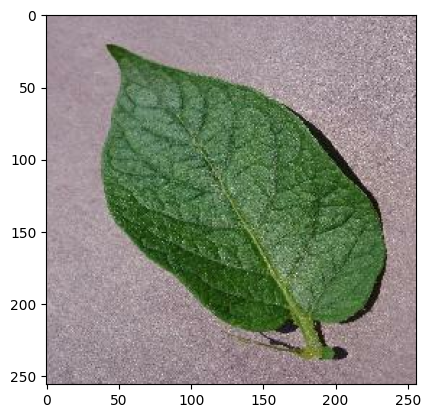

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


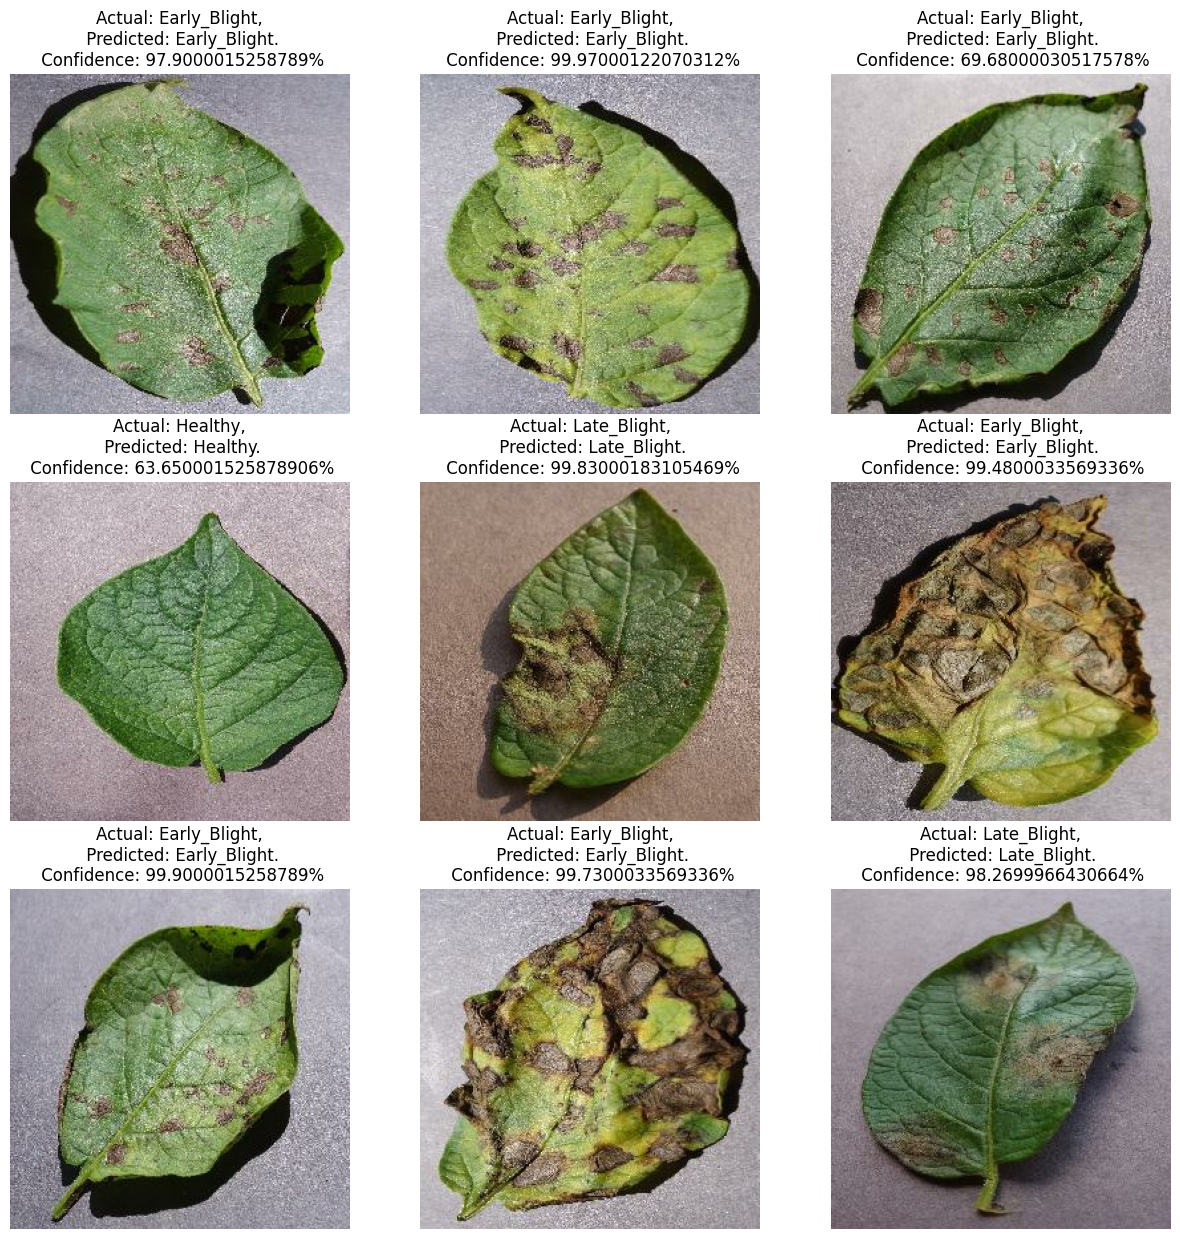

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [51]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [55]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9107 - loss: 0.1777


In [56]:
scores

[0.20942401885986328, 0.89453125]